## ANALYSE DE SENSIBILITE DU MODEL HYDRO R-NIAYES 2040

In [1]:
create_folder<-function(x,path=getwd()){
    
        for (f in x){
            
            folder<-file.path(path, f)

        if (!dir.exists(folder)){
            dir.create(folder)
            print(paste(f,"has been created!"))
        } else {
        print(paste(folder,"already exists!"))}
        }
}

In [2]:
rcsv_sep<-function(file_path){
    L <- readLines(file_path, n = 1)
    if (grepl(";", L)) read.csv2(file_path) else read.csv(file_path)
    }

In [35]:
normaliz_zero<-function(x){
    x<-na.omit(x)
    min<-min(x)
    max<-max(x)
    if (min!=max){
        val<-as.numeric(lapply(x,function(y) (y-min)/(max-min)))}
    else{
        if (max==0){val<-0}
        else{val<-1}
    }
return(val)
}

### Méthode de Morris

In [180]:
morris<-function(table,stats = "rmse_agg_dgpz"){
    #méthode de Morris: Le plan de morris avec échantillonnage radial itéré
    #plan d'expérience OAT
    plan<-sapply(table,unique)#plan brut
    plan<- data.frame(lapply(plan, function(x) {
      x <- unlist(x)
      length(x) <- max(lengths(plan))
      return(x)}))
    #normalisation du plan d'expérience
    table_norm<-table
    table_norm<-data.frame(sapply(table,normaliz_zero))
    plan_oat<-table_norm
    #la méthode moriss
    set.seed(123)
    i<-0
    EE<-c()
    PARAM<-c()
    choc<-c()
    response<-c()
    while (i<10){
        i<- i+1
        t<-c()
        T<-0
            #premier plan OAT
                ##trier au hasard l'état initial des paramètre du plan OAT
                L0<-sample(dim(plan_oat)[1],1)
                input0 <- plan_oat[L0,which(names(plan_oat)!=stats)]
                ##appel initial au model (réponse du model au set initial de paramètres)
                output0 <- plan_oat[L0,stats]
            while (T<10){
                #effets elementaire
                #tirage aléatoire pour modification d'une entrée
                to<-sample(length(input0),1)
                #modification du parametre choqué:
                input1 <- input0
                c<-0
                lt<-unique(unlist(na.omit(plan_oat[to])))
                lt<-as.list(lt[-which(lt==input0[[to]])])
                if (length(lt)!=0){
                    while (c<1){
                        chg<-sample(lt,1)[[1]]
                        input1[to]<-chg
                        p<-plan_oat
                        for (col in names(p[which(names(p)!=stats)])){
                            p <- p[which(p[,col]==input1[[col]]),]}
                        input1 = p
                        #le pas de changement
                        d<-(chg-input0[to])
                        if (NROW(input1)>0){
                            c<-1}
                        if (NROW(input1)==0){
                            input1 <- input0
                            lt<-lt[-which(lt==chg)]}
                        }
                    #appel au model choqué
                    output1 <- input1[,stats]
                    input1 <- input1[L0,which(names(plan_oat)!=stats)]
                    #effet élémentaire EE
                    EE1<-(output1-output0)/d
                    EE <-c (EE,round(EE1,3))
                    PARAM<- c(PARAM,names(input1)[to])
                    choc<-c(choc,d)
                    response<-c(response,round((output1-output0),3))
                    }
                    t<-c(t,to)
                    T<-sum(unique(t))
            }
    }
    #table des effets elementaires
    ee_morris <- data.frame(cbind(unlist(PARAM),unlist(EE),
                                  unlist(choc),unlist(response)))
    rownames(ee_morris) <-NULL 
    ee_morris[2:4]<-sapply(ee_morris[2:4],as.numeric)
    ee_morris[1]<-sapply(unlist(ee_morris[1]),as.factor)
    names(ee_morris) <- c("parametres","effet_elementaire",
                          "delta_X","delta_Y")
    morris<-plan[which(plan[1]=="moire"),which(names(plan)!=stats)]
    for (j in 1:NCOL(morris)){
        morris["mean_effect",j]<-round(mean((ee_morris[which(ee_morris[1]==names(morris)[j]),2]),
                                            na.rm=TRUE),3)
        morris["mean_absolute_effect",j]<-round(mean(abs(ee_morris[which(ee_morris[1]==names(morris)[j]),2]),
                                                     na.rm=TRUE),3)
        morris["sd_effect",j]<-round(sd(ee_morris[which(ee_morris[1]==names(morris)[j]),2],
                                        na.rm=TRUE),3)
        morris["delta_X",j]<-round(mean(ee_morris[which(ee_morris[1]==names(morris)[j]),3],
                                        na.rm=TRUE),3)
        morris["delta_Y",j]<-round(mean(ee_morris[which(ee_morris[1]==names(morris)[j]),4],
                                        na.rm=TRUE),3)}
    morris<-t(morris)
    morris<-na.omit(morris)
    #plan de morris
    plt<-data.frame(morris)
    plot(x = plt$mean_absolute_effect,
         y = plt$sd_effect,
         pch = 16, frame = FALSE,
         xlab = "moyenne des effets élémentaires absolus", 
         ylab = "l’écart-type des effets élémentaires",
         col = c(1:NCOL(plt)))
    if (NROW(plt)>1){
    abline(lm(sd_effect ~ mean_absolute_effect + mean_absolute_effect,data=plt,na.action=na.omit),col="grey", lwd=3)}
    #text(sd_effect ~ mean_effect, labels=rownames(plt),data=plt, cex=0.9, font=2)
    text(plt$mean_absolute_effect,plt$sd_effect,labels=rownames(plt), cex= 0.7, offset = 10)
    write.csv2(ee_morris, file = "effet_elementaire_morris.csv")
    #rank de morris
    rank<-data.frame(plt[,2:3])
    return(rank)
    rank$sum<-(rank$sd_effect+rank$mean_absolute_effect)
    print("out")
    rank<-rank[order(rank$sum),]
    rank$Rang_Morris<-sort(1:NROW(rank),decreasing=TRUE)
    rank<-rank[order(rank$Rang_Morris),-3]
    
return(rank)}

- les paramètres d'entrée

#### importer les données

In [22]:
path_table = 'C:/Users/kouno/Desktop/Programme_Crésus/Calibration Model Hydro/output/tableau_rsme.csv'
rmse<-rcsv_sep(path_table)[-1]

#### mise en forme de la table

In [23]:
#selection des resolutions à considérer
rmse[3:7]<-data.frame(lapply(rmse[3:7],as.numeric))
set<-subset(rmse,resolution==300|resolution==500|
            resolution==700|resolution==900)
#selection des variables à considérer
table<-set[,c("consourb","moyirrigculture","varstock","resolution","rmse_agg_dgpz")]

,mean_absolute_effect,sd_effect
,<dbl>,<dbl>
moyirrigculture,1.466,1.907


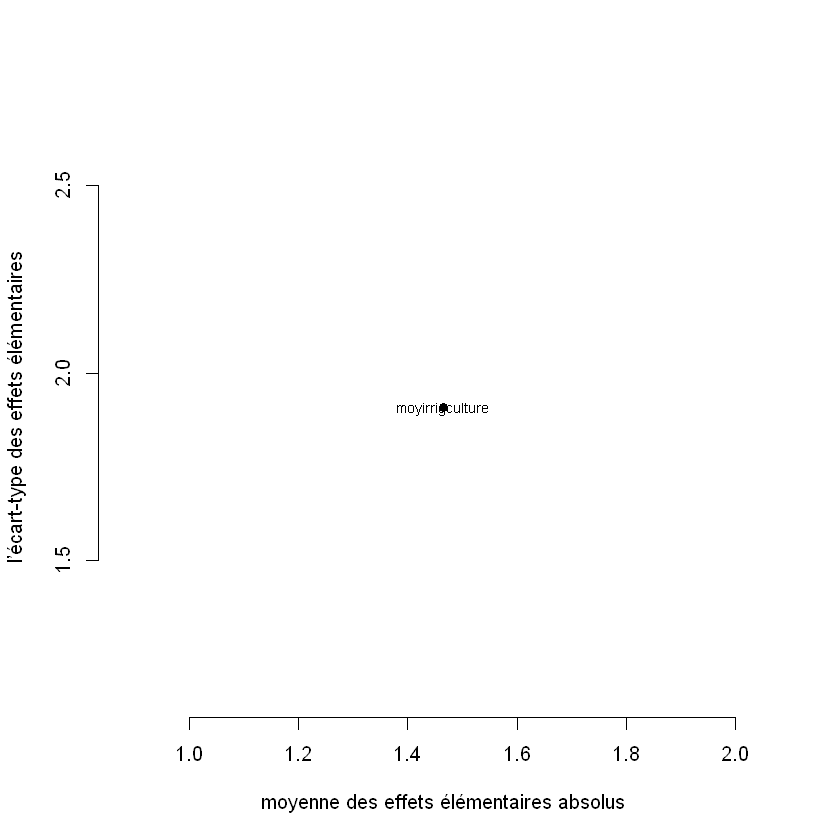

In [183]:
morris(table)